# Trabalho de conclusão de curso

## Previsão do risco de morte após uma operação cardíaca utilizando o EuroSCORE

O EuroSCORE (Sistema Europeu de Risco em Operações Cardíacas) é um modelo de risco que permite o cálculo do risco de morte após uma operação cardíaca.  
O modelo solicita 17 itens de informação sobre o paciente, o estado do coração e a operação proposta, e utiliza regressão logística para calcular o risco de morte.

Calculadora EuroSCORE  
http://www.euroscore.org/calc.html

Base de dados  
https://plos.figshare.com/articles/Is_the_EuroSCORE_II_reliable_to_estimate_operative_mortality_among_octogenarians_/5608465

## Alunos: Edson Pires Nunes e Marcelo Fernandes

In [ ]:
#Para rodar o profiling sem erros é necessário atualizar o ambiente e depois instalar o pandas_profiling do source
#!conda update -n base conda -y
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
#Instalação do PyCaret, biblioteca que simplifica a aplicação de regressão e classificação
#!pip install pycaret
#!pip install shap

In [2]:
import pandas as pd
import pandas_profiling
import os.path
from pycaret.regression import *
from pycaret.utils import check_metric
from sklearn.model_selection import train_test_split

In [3]:
def clean_dataframe_column_names(df):
    return [col.lstrip()
            .rstrip()
            .lower()
            .replace(" ", "_")
            .replace("<>", "")
            .replace(">", "_larger_than_")
            .replace("<", "_less_than_") for col in df.columns]

def save_eda(fileName, df):
    if not os.path.isfile(fileName):
        pfr = pandas_profiling.ProfileReport(df)
        pfr.to_file(fileName)
    else:
        print (f"EDA already saved, please check {fileName}")

In [4]:
raw_data = pd.read_excel("data/raw/Euroscore.xls")

## Análise exploratória e descritiva

In [5]:
save_eda("EDA_Raw.html",raw_data)

EDA already saved, please check EDA_Raw.html


## Pré Processamento

In [6]:
# Preenchendo os valores NaN com a média
raw_data = raw_data.fillna(raw_data.mean())

# Preenchendo os valores string com "No" (Valor mais provável)
raw_data = raw_data.fillna("No")

#Remover duplicadas (1 observação)
raw_data.drop_duplicates(inplace=True)

#Variáveis binárias de Yes/No para 1/0
for cl in raw_data.select_dtypes(include=["object"]):
    raw_data[cl] = raw_data[cl].apply(lambda _: str(_).lower())
    if raw_data.groupby(cl)[cl].nunique().count() == 2:
        raw_data[cl] = raw_data[cl].map(dict(yes=1, no=0)).fillna(raw_data[cl])

#Geração dos dummies
raw_data = pd.get_dummies(raw_data)

#Limpeza do nome das colunas
raw_data.columns = clean_dataframe_column_names(raw_data)

#Backup em CSV
raw_data.to_csv("data\processed\pre_processed.csv", index=False)

#Liberar memória para a variável não usada
del raw_data

In [7]:
#Recaregar CSV previamente salvo
pre_processed_data = pd.read_csv("data\processed\pre_processed.csv")
save_eda("EDA_Pre_Processed.html", pre_processed_data)

EDA already saved, please check EDA_Pre_Processed.html


## Processamento

### Colunas removidas por alta correlação positiva ou por irrelevância na análise
es1 -- Vamos comparar com ES2    
d30death --Desconsiderar mortes dentro de 30 dias  
intrahospitaldeath --Desconsiderar mortes  
neurologic_dysfunction_a is highly correlated with neurologic_dysfunction --(iguais) manter segunda  
activeendocarditis_b is highly correlated with activeendocarditis --(iguais) manter segunda  
urgency_a is highly correlated with urgency --(iguais) manter segunda  
valvularsurgery is highly correlated with valvulopathy --(iguais) manter segunda  
coronaryarterydisease is highly correlated with cabg --(varia mais) manter segunda  
aa2 is highly correlated with aa --(varia mais) manter segunda  
clearancecock is highly correlated with clearance --(similares, menos casas decimais na segunda) manter segunda  
diabetes__status_insulin is highly correlated with diabetesoninsulin --(iguais) manter segunda  
delaimi is highly correlated with acs__larger_than__90_d --(iguais) manter segunda  
redo is highly correlated with previous_cardiac_surgery_no --(quase iguais) manter segunda  
extracardiac_arteriopathy_a is highly correlated with extracardiac_arteriopathy_no --(iguais) manter segunda  
copdeurosc_a is highly correlated with copd_yes_treated --(iguais) manter segunda  
cardiac_rhythm_fa_ou_tsv is highly correlated with cardiac_rhythm_sinusal --(iguais) manter segunda  
surgerythoracicaorta is highly correlated with ascendingaortasurgery_no --(iguais) manter segunda  
others.1_tumor is highly correlated with others_tumor --(iguais) manter segunda  
  
### Apesar da correlação, vamos manter essas colunas pois tratam de coisas diferentes  
neoplasia_no is highly correlated with neoplasia__less_than_5years --manter as 2, tratam de categorias diferentes  
triscupid_valve_repair is highly correlated with triscupid_no --manter as 2, tratam de categorias diferentes  
surg is highly correlated with procedure and 1 other fields  --manter as 2, tratam de categorias diferentes  
procedure is highly correlated with surg and 1 other fields  --manter as 2, tratam de categorias diferentes  
weightofproc_isolated_cabg is highly correlated with procedure and 1 other fields  --manter as 2, tratam de categorias diferentes  

In [8]:
colsToDrop = ["es1","d30death","neurologic_dysfunction_a","activeendocarditis_b","urgency_a",
"valvularsurgery","coronaryarterydisease","aa2","clearancecock","diabetes__status_insulin","delaimi",
"redo","extracardiac_arteriopathy_a","copdeurosc_a","cardiac_rhythm_fa_ou_tsv","surgerythoracicaorta","others.1_tumor",
"intrahospitaldeath"]
pre_processed_data = pre_processed_data.drop(colsToDrop, axis=1)

In [9]:
# Salvar dados processados em CSV
pre_processed_data.to_csv("data\processed\processed.csv", index=False)
# Liberar memória
del pre_processed_data
#Recaregar CSV previamente salvo
processed_data = pd.read_csv("data\processed\processed.csv")
save_eda("EDA_Processed.html", processed_data)

EDA already saved, please check EDA_Processed.html


In [10]:
# Separação em treinamento e validação
data_train, data_validation = train_test_split(processed_data, test_size=0.3, random_state=42)

## Regressão

In [11]:
# Setup dos modelos de regressão
exp_reg = setup(data_train, target="es2")

 
Setup Succesfully Completed.


,Description,Value
0,session_id,6956
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(5012, 157)"
4,Missing Values,False
5,Numeric Features,11
6,Categorical Features,145
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [12]:
# Treinamento e comparação dos modelos de regressão
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,0.7358,6.1132,2.3225,0.9289,0.1186,0.1206,19.1117
1,Gradient Boosting Regressor,1.1964,7.8267,2.7369,0.8997,0.2471,0.3320,2.4399
2,Light Gradient Boosting Machine,0.9983,8.8006,2.9034,0.8855,0.1702,0.1574,0.4147
3,Extreme Gradient Boosting,0.9946,9.2360,2.9620,0.8793,0.1603,0.1554,2.1340
4,Random Forest,1.1981,10.9639,3.2310,0.8590,0.1999,0.1867,4.0507
5,Extra Trees Regressor,1.3049,12.2657,3.4266,0.8405,0.2166,0.2040,5.1630
6,TheilSen Regressor,2.0509,17.3938,4.0967,0.7746,0.3641,0.7319,160.1825
7,Bayesian Ridge,2.2987,17.0039,4.0752,0.7725,0.4195,0.9864,0.2797
8,Ridge Regression,2.3043,17.0815,4.0869,0.7707,0.4210,0.9872,0.0666
9,Orthogonal Matching Pursuit,2.2869,17.1798,4.0991,0.7688,0.4118,0.9704,0.0701


&lt;catboost.core.CatBoostRegressor at 0x1c7e3aa4808&gt;

In [17]:
#Criação do modelo usando o de melhor desempenho
trained_model = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.9901,10.2726,3.2051,0.9125,0.1294,0.1206
1,0.5708,2.1605,1.4699,0.9644,0.1031,0.1142
2,0.8399,8.8445,2.9740,0.9332,0.1116,0.1136
3,1.0048,15.8001,3.9749,0.8710,0.1346,0.1250
4,0.7187,4.5870,2.1417,0.9292,0.1238,0.1317
5,0.8256,6.1738,2.4847,0.9082,0.1249,0.1265
6,0.5780,3.0754,1.7537,0.9446,0.1139,0.1156
7,0.7144,6.7537,2.5988,0.9044,0.1218,0.1256
8,0.5299,1.4274,1.1947,0.9581,0.1093,0.1145
9,0.5859,2.0366,1.4271,0.9639,0.1139,0.1185


In [18]:
# Ajuste dos hiperparâmetros
tuned_catboost = tune_model(trained_model)
print(trained_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0457,6.1987,2.4897,0.9472,0.1749,0.2074
1,0.7259,2.4684,1.5711,0.9593,0.1640,0.2030
2,0.8990,6.3152,2.5130,0.9523,0.1614,0.2036
3,1.0474,8.8137,2.9688,0.9280,0.1780,0.2148
4,0.8262,3.5121,1.8741,0.9458,0.1814,0.2274
5,0.8938,4.1034,2.0257,0.9390,0.1653,0.2087
6,0.7363,2.8944,1.7013,0.9478,0.1686,0.2206
7,0.8216,3.7191,1.9285,0.9473,0.1695,0.2167
8,0.7304,1.9007,1.3787,0.9442,0.1636,0.1963
9,0.8097,2.3525,1.5338,0.9583,0.1696,0.2179


&lt;catboost.core.CatBoostRegressor object at 0x000001C7E4565BC8&gt;


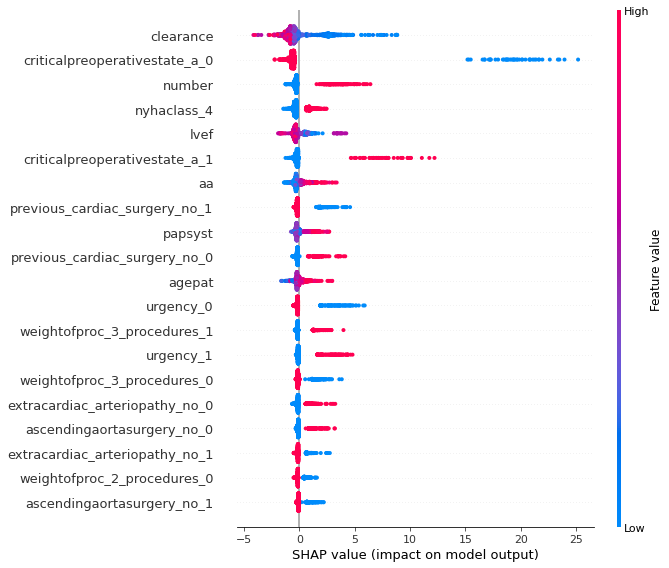

In [24]:
# Plotagem do impacto das features no modelo
interpret_model(tuned_catboost)

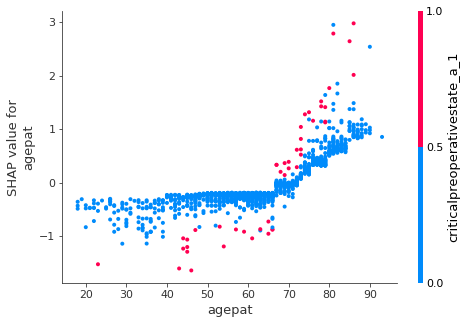

In [26]:
# Plotagem da correlação
interpret_model(tuned_catboost, plot = 'correlation')

In [27]:
#Peso das features
interpret_model(tuned_catboost,  plot = 'reason', observation = 10)

&lt;IPython.core.display.HTML object&gt;

&lt;shap.plots._force.AdditiveForceVisualizer at 0x1c7e263b988&gt;

In [29]:
# Predição na base de validação
unseen_predictions = predict_model(tuned_catboost, data=data_validation)

In [30]:
check_metric(unseen_predictions.es2, unseen_predictions.Label, 'R2')

0.9487